# Préambule
___

In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.linear_model import Ridge


from utils.financial_tools import sharpe_ratio

np.random.seed(42)

## Handling the data
___

In [2]:
# Load the data
file_path = "data/high_10m.parquet"

table1 = pd.read_parquet(file_path)

In [3]:
table1.head()

,DATE,SYMBOL,TIME,ALL_EX,MID_OPEN,SUM_DELTA,RETURN
0,2021-12-01,A,09:30:00,DNYBTJVPCZUKXHA,152.190,-8.401819,0.000000
1,2021-12-01,A,09:40:00,PBTJVDZUYKNHCXM,150.490,0.473357,-0.011170
2,2021-12-01,A,09:50:00,KDPBTJVNZUCXYH,151.475,-10.867709,0.006545
3,2021-12-01,A,10:00:00,DABTJNKYVPZUXCH,150.510,-0.125414,-0.006371
4,2021-12-01,A,10:10:00,DVJTPNKUZYACBXHM,151.960,-1.274648,0.009634


In [4]:
# Create a timestamp column
table1['timestamp'] = pd.to_datetime(table1['DATE'].dt.strftime('%Y-%m-%d') + ' ' + table1['TIME'])
table1 = table1.set_index('timestamp')

In [5]:
table1 = table1.drop(['DATE', 'TIME'], axis=1, errors='ignore')

In [6]:
table1

,SYMBOL,ALL_EX,MID_OPEN,SUM_DELTA,RETURN
timestamp,,,,,
2021-12-01 09:30:00,A,DNYBTJVPCZUKXHA,152.190,-8.401819,0.000000
2021-12-01 09:40:00,A,PBTJVDZUYKNHCXM,150.490,0.473357,-0.011170
2021-12-01 09:50:00,A,KDPBTJVNZUCXYH,151.475,-10.867709,0.006545
2021-12-01 10:00:00,A,DABTJNKYVPZUXCH,150.510,-0.125414,-0.006371
2021-12-01 10:10:00,A,DVJTPNKUZYACBXHM,151.960,-1.274648,0.009634
...,...,...,...,...,...
2021-12-31 15:00:00,ZYXI,DVJPQUZN,10.055,-0.050725,-0.006914
2021-12-31 15:10:00,ZYXI,DQKJVUZ,10.040,-0.032836,-0.001492
2021-12-31 15:20:00,ZYXI,QNKUZPDJV,10.040,-0.059878,0.000000


In [7]:
# Create the lags for each stock
lags = 10
train_window = 50

for lag in range(lags+1):
    table1[f'return_lag_{lag}'] = table1.groupby('SYMBOL')['RETURN'].shift(lag)

# Drop NaN values
table1 = table1.dropna()

In [8]:
# Take some random stocks
nb_random_stocks = 500
list_of_symbols = table1['SYMBOL'].unique()

random_stocks = np.random.choice(list_of_symbols, nb_random_stocks)
table2 = table1[table1['SYMBOL'].isin(random_stocks)]

## Useful functions
___

In [9]:
def rolling_sampling(data: pd.DataFrame, train_window: int = 6):
    """
    Generates rolling window splits for time series training and testing.

    This function creates temporal splits using a rolling window approach for training
    and testing data. It works with a timestamp-indexed Pandas DataFrame and a fixed
    window size.

    Args:
        data: Input Pandas DataFrame with temporal index.
        train_window: Number of time intervals for the training window.
                     Represents how many historical data points are used
                     for training. Default: 6 intervals.

    Returns:
        A tuple containing two lists:
        - splitting_train: List of temporal indices for each training window
        - splitting_test: List of temporal indices for each corresponding test point

    Example:
        >>> df = pd.DataFrame(...) # DataFrame with temporal index
        >>> train_splits, test_splits = rolling_sampling(df, train_window=10)
    """

    list_of_dates = data.index.unique()
    number_of_splits = len(list_of_dates) - train_window

    splitting_train = []  # Initialize as empty lists
    splitting_test = []

    for split in range(number_of_splits):
        # Append date ranges as lists to splitting_train
        splitting_train.append(list_of_dates[split : split + train_window])
        # Append single dates to splitting_test
        splitting_test.append(list_of_dates[split + train_window])

    return splitting_train, splitting_test

# Linear Regression
___

In [14]:
from sklearn.linear_model import LinearRegression

def run_regression_for_symbol(symbol, group):
    group = group.sort_values("timestamp")
    splitting_train, splitting_test = rolling_sampling(group, train_window)

    results = []

    for slice_train, slice_test in zip(splitting_train, splitting_test):
        window_data = group.loc[slice_train.union([slice_test])]

        X = window_data[[f'return_lag_{lag}' for lag in range(1, lags + 1)]]
        y = window_data['RETURN']

        X_train = X.iloc[:-1]
        X_test = X.iloc[[-1]]

        y_train = y.iloc[:-1].values
        y_test = y.iloc[-1]

        reg = LinearRegression().fit(X_train, y_train)
        y_pred = reg.predict(X_test)

        results.append({
            'symbol': symbol,
            'timestamp': slice_test,
            'y_true': y_test,
            'y_pred': y_pred[0],
            'managed_return': np.sign(y_pred[0]) * y_test
        })

    return results


In [15]:
# Run in parallel over all symbols
results = Parallel(n_jobs=-1)(
    delayed(run_regression_for_symbol)(symbol, group)
    for symbol, group in tqdm.tqdm(table2.groupby("SYMBOL"))
)

# Flatten the nested list of predictions
all_predictions = [item for sublist in results for item in sublist]

# Convert to DataFrame
df_predictions = pd.DataFrame(all_predictions).set_index(['symbol', 'timestamp'])




  0%|          | 0/486 [00:00<?, ?it/s]


  8%|▊         | 40/486 [00:01<00:20, 21.37it/s]


 12%|█▏        | 60/486 [00:04<00:32, 13.25it/s]


 16%|█▋        | 80/486 [00:06<00:34, 11.81it/s]


 21%|██        | 100/486 [00:07<00:33, 11.63it/s]


 25%|██▍       | 120/486 [00:09<00:32, 11.43it/s]


 29%|██▉       | 140/486 [00:10<00:26, 13.09it/s]


 33%|███▎      | 160/486 [00:12<00:26, 12.33it/s]


 37%|███▋      | 180/486 [00:14<00:23, 12.85it/s]


 41%|████      | 200/486 [00:15<00:22, 12.82it/s]


 45%|████▌     | 220/486 [00:17<00:20, 12.79it/s]


 49%|████▉     | 240/486 [00:18<00:18, 13.21it/s]


 53%|█████▎    | 260/486 [00:20<00:17, 12.99it/s]


 58%|█████▊    | 280/486 [00:21<00:15, 13.04it/s]


 62%|██████▏   | 300/486 [00:23<00:13, 13.39it/s]


 66%|██████▌   | 320/486 [00:24<00:12, 13.40it/s]


 70%|██████▉   | 340/486 [00:26<00:11, 12.94it/s]


 74%|███████▍  | 360/486 [00:27<00:10, 12.60it/s]


 78%|███████▊  | 380/486 [00:29<00:08, 13.12it/s]


 82%|████████▏ | 400/4

## Scores

In [16]:
r2 = r2_score(df_predictions['y_true'], df_predictions['y_pred'])
mae = mean_absolute_error(df_predictions['y_true'], df_predictions['y_pred'])

print(f"Overall R²: {r2:.4f}")
print(f"Overall MAE: {mae:.6f}")

Overall R²: -3.1245
Overall MAE: 0.004009


## Managed returns

In [17]:
all_managed_returns = []

# Computing the managed return
managed_return = np.sign(df_predictions['y_pred']) * df_predictions['y_true'] #go long if positive prediction, go short if negative prediction
df_predictions['managed_return'] = managed_return

In [18]:
realized_returns = df_predictions[['managed_return']].groupby(level=1).mean()
df_cum = realized_returns.cumsum()
real_returns = df_predictions[['y_true']].groupby(level=1).mean()
df_real_cum = real_returns.cumsum()

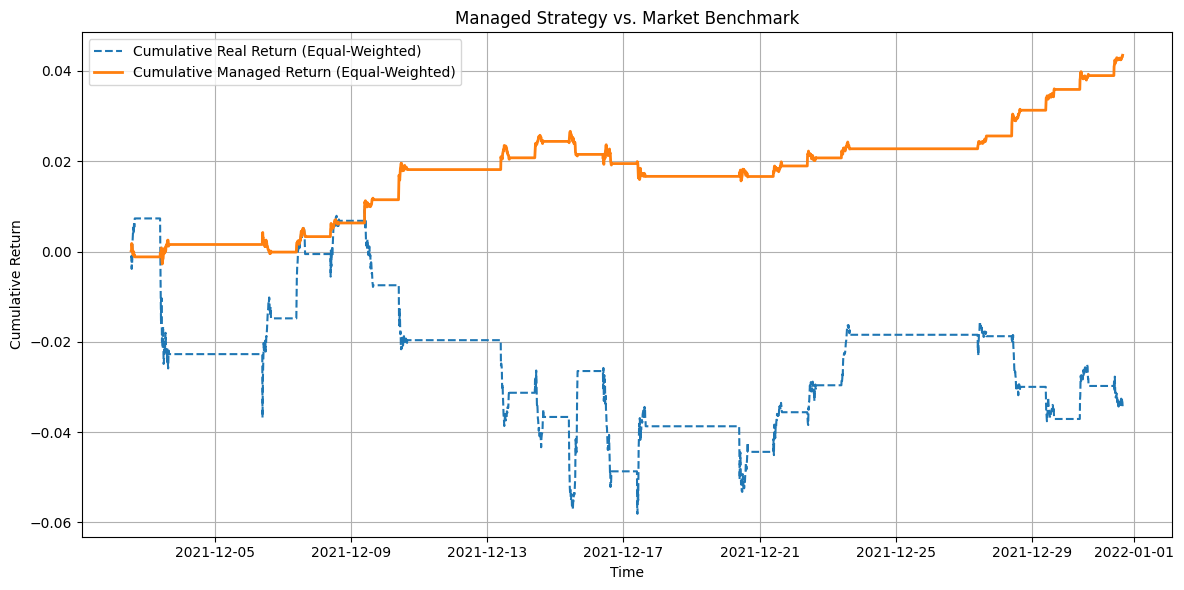

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(df_real_cum, label="Cumulative Real Return (Equal-Weighted)", linestyle="--")
plt.plot(df_cum, label="Cumulative Managed Return (Equal-Weighted)", linewidth=2)
plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.title("Managed Strategy vs. Market Benchmark")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
tmp = df_predictions[['y_true','managed_return']].groupby(level=1).mean()
tmp = tmp/tmp.std()

sr = sharpe_ratio(tmp)

In [21]:
print(sr)

y_true           -0.09
managed_return    0.38
dtype: float64


# Ridge regression (non-random)
___

In [22]:
shrinkage_list = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]

def run_ridge_for_symbol(symbol, group):
    group = group.sort_values("timestamp")
    splitting_train, splitting_test = rolling_sampling(group, train_window)

    results = []

    for slice_train, slice_test in zip(splitting_train, splitting_test):
        window_data = group.loc[slice_train.union([slice_test])]
        X = window_data[[f'return_lag_{lag}' for lag in range(1, lags + 1)]]
        y = window_data['RETURN']

        X_train = X.iloc[:-1]
        X_test = X.iloc[[-1]]
        y_train = y.iloc[:-1]
        y_test = y.iloc[-1]

        for alpha in shrinkage_list:
            clf = Ridge(alpha=alpha)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            results.append({
                'symbol': symbol,
                'timestamp': slice_test,
                'alpha': alpha,
                'y_true': y_test,
                'y_pred': y_pred[0],
                'managed_return': np.sign(y_pred[0]) * y_test
            })

    return results

In [23]:
# Run in parallel over all symbols
results = Parallel(n_jobs=-1)(
    delayed(run_ridge_for_symbol)(symbol, group)
    for symbol, group in tqdm.tqdm(table2.groupby("SYMBOL"))
)

# Flatten the nested list of predictions
all_predictions = [item for sublist in results for item in sublist]

# Convert to DataFrame
df_predictions = pd.DataFrame(all_predictions).set_index(['symbol', 'timestamp'])




  0%|          | 0/486 [00:00<?, ?it/s]


 16%|█▋        | 80/486 [00:10<00:54,  7.44it/s]


 25%|██▍       | 120/486 [00:20<01:06,  5.47it/s]


 29%|██▉       | 140/486 [00:38<01:57,  2.95it/s]


 33%|███▎      | 160/486 [00:48<02:07,  2.57it/s]


 37%|███▋      | 180/486 [00:55<01:54,  2.68it/s]


 41%|████      | 200/486 [01:02<01:45,  2.71it/s]


 45%|████▌     | 220/486 [01:10<01:38,  2.70it/s]


 49%|████▉     | 240/486 [01:17<01:32,  2.66it/s]


 53%|█████▎    | 260/486 [01:35<01:57,  1.93it/s]


 58%|█████▊    | 280/486 [01:51<02:05,  1.65it/s]


 62%|██████▏   | 300/486 [01:59<01:39,  1.87it/s]


 66%|██████▌   | 320/486 [02:07<01:24,  1.97it/s]


 70%|██████▉   | 340/486 [02:13<01:03,  2.28it/s]


 74%|███████▍  | 360/486 [02:21<00:54,  2.32it/s]


 78%|███████▊  | 380/486 [02:29<00:44,  2.39it/s]


 82%|████████▏ | 400/486 [02:35<00:32,  2.64it/s]


 86%|████████▋ | 420/486 [02:43<00:25,  2.58it/s]


 91%|█████████ | 440/486 [02:51<00:18,  2.53it/s]


 95%|█████████▍| 460

## Scores

In [30]:
r2 = r2_score(df_predictions['y_true'], df_predictions['y_pred'])
mae = mean_absolute_error(df_predictions['y_true'], df_predictions['y_pred'])

print(f"Overall R²: {r2:.4f}")
print(f"Overall MAE: {mae:.6f}")

Overall R²: -0.1590
Overall MAE: 0.003305


## Managed returns

In [32]:
df_predictions = df_predictions.reset_index()

In [33]:
df_market_returns = df_predictions.groupby('timestamp')['y_true'].mean()
df_market_returns.head(5)

timestamp
2021-12-02 13:10:00   -0.001284
2021-12-02 13:20:00    0.000296
2021-12-02 13:30:00   -0.002860
2021-12-02 13:40:00    0.002707
2021-12-02 13:50:00   -0.001383
Name: y_true, dtype: float64

In [34]:
df_market_timing = df_predictions[['symbol','timestamp','alpha','y_pred','managed_return']]
df_market_timing.head(5)

,symbol,timestamp,alpha,y_pred,managed_return
0,AACG,2021-12-03 09:50:00,0.0001,-0.009234,0.016892
1,AACG,2021-12-03 09:50:00,0.0010,-0.008098,0.016892
2,AACG,2021-12-03 09:50:00,0.0100,-0.004315,0.016892
3,AACG,2021-12-03 09:50:00,0.1000,-0.001963,0.016892
4,AACG,2021-12-03 09:50:00,1.0000,-0.001573,0.016892


In [35]:
df_market_timing = pd.pivot_table(df_market_timing, values=['managed_return'], index=['symbol', 'timestamp'],
                       columns=['alpha'], aggfunc="mean")
df_market_timing.head(5)

managed_return                                \
alpha                            0.0001    0.0010    0.0100    0.1000     
symbol timestamp                                                          
AACG   2021-12-03 09:50:00       0.016892  0.016892  0.016892  0.016892   
       2021-12-03 10:00:00      -0.003436  0.003436  0.003436  0.003436   
       2021-12-03 10:10:00      -0.010345 -0.010345  0.010345  0.010345   
       2021-12-03 10:20:00       0.020906  0.020906  0.020906  0.020906   
       2021-12-03 10:30:00       0.000000  0.000000  0.000000  0.000000   

                                                          
alpha                       1.0000    10.0000   100.0000  
symbol timestamp                                          
AACG   2021-12-03 09:50:00  0.016892  0.016892  0.016892  
       2021-12-03 10:00:00  0.003436  0.003436  0.003436  
       2021-12-03 10:10:00  0.010345  0.010345  0.010345  
       2021-12-03 10:20:00  0.020906  0.020906  0.020906  
       2021-12-03 10:30:00  0.000000  0.000000  0.000000

In [36]:
df_market_timing = df_market_timing.groupby(level=1).mean()
df_market_timing.head(5)

managed_return                                          \
alpha                     0.0001    0.0010    0.0100    0.1000    1.0000     
timestamp                                                                    
2021-12-02 13:10:00       0.000128  0.000315  0.001000  0.001278  0.001403   
2021-12-02 13:20:00       0.000136  0.000114 -0.000376 -0.000348 -0.000191   
2021-12-02 13:30:00       0.001616  0.001828  0.002246  0.002593  0.002453   
2021-12-02 13:40:00      -0.000274 -0.000458 -0.001815 -0.002525 -0.002503   
2021-12-02 13:50:00      -0.000043  0.000068  0.000745  0.001149  0.001142   

                                         
alpha                10.0000   100.0000  
timestamp                                
2021-12-02 13:10:00  0.001396  0.001396  
2021-12-02 13:20:00 -0.000191 -0.000191  
2021-12-02 13:30:00  0.002385  0.002385  
2021-12-02 13:40:00 -0.002262 -0.002262  
2021-12-02 13:50:00  0.001142  0.001142

In [37]:
tmp = pd.concat([df_market_returns,df_market_timing], axis = 1)
tmp = tmp/tmp.std()
sr = sharpe_ratio(tmp)

In [38]:
market_returns = tmp['y_true']
managed_returns = tmp.iloc[:,1:]

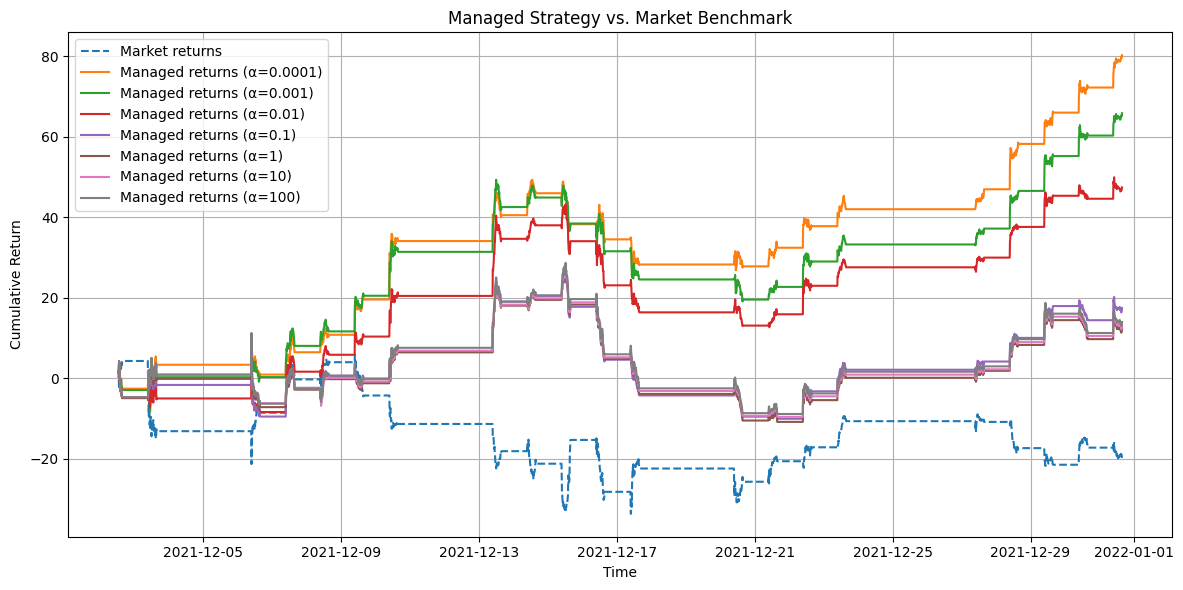

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(market_returns.cumsum(), label="Market returns", linestyle="--")

for alpha in shrinkage_list:

    plt.plot(
       managed_returns.cumsum()[('managed_return', alpha)],
       label=f"Managed returns (α={alpha})"
    )

plt.xlabel("Time")
plt.ylabel("Cumulative Return")
plt.title("Managed Strategy vs. Market Benchmark")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
print(sr)

y_true                     -0.09
(managed_return, 0.0001)    0.36
(managed_return, 0.001)     0.29
(managed_return, 0.01)      0.21
(managed_return, 0.1)       0.08
(managed_return, 1.0)       0.06
(managed_return, 10.0)      0.06
(managed_return, 100.0)     0.06
dtype: float64
